## Convolutiona neural network on the hand written digit image set from pytorch libray


In this lab, the CNN model was trained with the hand written digit image set. The model was train with the image set augmented to 30 degree, trained using dropout and initializing momentum

In [1]:
#install torchvision
!pip install torchvision

#mporting libraries
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pylab as plt
import numpy as np
import torch.nn.functional as F
import time

We will vizualizie our model kernel parameters for each channel using this function

In [2]:
# Define the function for plotting the channels

def plot_channels(W):
    n_out = W.shape[0]
    n_in = W.shape[1]
    w_min = W.min().item()
    w_max = W.max().item()
    fig, axes = plt.subplots(n_out, n_in)
    fig.subplots_adjust(hspace=0.1)
    out_index = 0
    in_index = 0
    
    #plot outputs as rows inputs as columns 
    for ax in axes.flat:
        if in_index > n_in-1:
            out_index = out_index + 1
            in_index = 0
        ax.imshow(W[out_index, in_index, :, :], vmin=w_min, vmax=w_max, cmap='seismic')
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        in_index = in_index + 1

    plt.show()

Define a function to plot the kernels of each channel with multiple output

In [3]:
# Define the function for plotting the parameters

def plot_parameters(W, number_rows=1, name="", i=0):
    W = W.data[:, i, :, :]
    n_filters = W.shape[0]
    w_min = W.min().item()
    w_max = W.max().item()
    fig, axes = plt.subplots(number_rows, n_filters // number_rows)
    fig.subplots_adjust(hspace=0.4)

    for i, ax in enumerate(axes.flat):
        if i < n_filters:
            # Set the label for the sub-plot.
            ax.set_xlabel("kernel:{0}".format(i + 1))

            # Plot the image.
            ax.imshow(W[i, :], vmin=w_min, vmax=w_max, cmap='seismic')
            ax.set_xticks([])
            ax.set_yticks([])
    plt.suptitle(name, fontsize=10)    
    plt.show()

Define the function <code>show_data</code> to plot out data samples as images.


In [4]:
def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(16, 16), cmap='gray')
    plt.title('y = '+ str(data_sample[1]))

<!--Empty Space for separating topics-->


In [5]:
#intializze data transformation
composed = transforms.Compose([transforms.Resize((16, 16)), transforms.ToTensor(), transforms.RandomRotation(degrees=30)])

In [6]:
#load train and validation set
train_dataset = dsets.MNIST(root='./data', train=True, download=True, transform=composed)
validation_dataset = dsets.MNIST(root='./data', train=False, download=True, transform=composed)

print('The number of images to be trained is {} and validation images are {}'.format(len(train_dataset), len(validation_dataset)))

The number of images to be trained is 60000 and validation images are 10000


In [7]:
# Show the data type for each element in dataset

type(train_dataset[0][1])

int

In [8]:
#view first element  label
train_dataset[0][1]

5

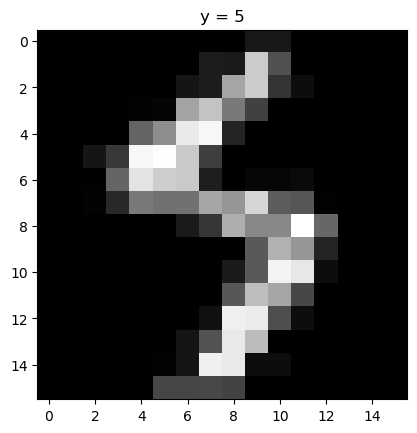

In [9]:
# The image for the fourth data element
show_data(train_dataset[0])


<!--Empty Space for separating topics-->


Network construction. The network has two convolutional layers, the output for the first is 16 and the ouput for the second is 32, each of the two convlutional layers has  kernel sizes of (5,5) and padding of 2, two max pooling layer of (2,2), output layer of 10 neurons.


In [10]:
class CNN(nn.Module):
    
    # Contructor
    def __init__(self, out_1=16, out_2=32):
        super(CNN, self).__init__()

        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.maxpool1=nn.MaxPool2d(kernel_size=2)

        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        self.fc1 =nn.Linear(out_2 * 4 * 4, 10)
       
    
    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x=self.fc1(x)
    
        return x
    
    
   

In [11]:
# Create the model object using CNN class

model = CNN()

In [12]:
model.state_dict()['cnn1.weight'][0].shape

torch.Size([1, 5, 5])

Plot the model parameters for the kernels before training the kernels. The kernels are initialized randomly.


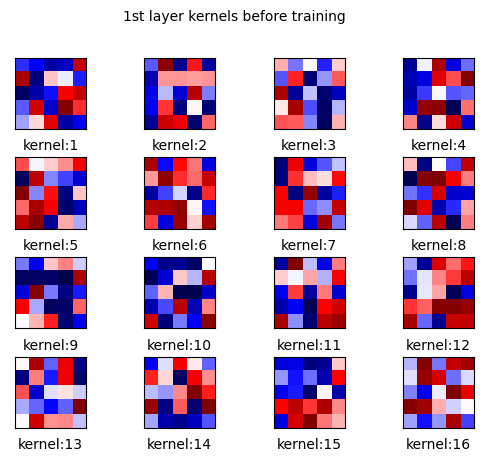

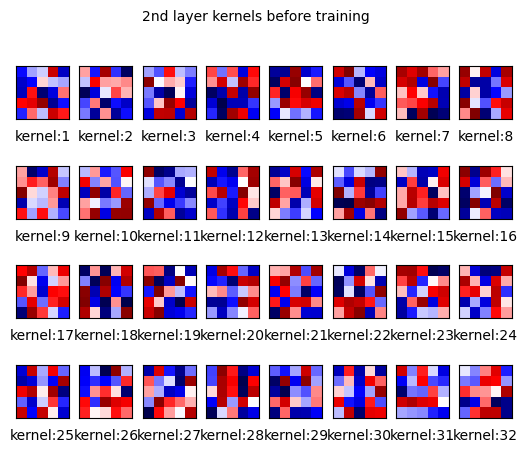

In [13]:
# Plot the parameters

plot_parameters(model.state_dict()['cnn1.weight'], number_rows=4, name="1st layer kernels before training ")
plot_parameters(model.state_dict()['cnn2.weight'], number_rows=4, name='2nd layer kernels before training' )

Initialize parameter for training. Training batch size of 100 samples each, validation batch size of 5000 sample each, learning rate of 0.4, momentum of 0.6, optimizer is gradient decent

In [14]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.2
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate,  momentum=0.5)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000)

Training face model. Training with 30 epochs


In [15]:
# Train the model

n_epochs=25
cost_list=[]
accuracy_list=[]
N_test=len(validation_dataset)
COST=0

def train_model(n_epochs):
    for epoch in range(n_epochs):
        COST=0
        for x, y in train_loader:
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            COST+=loss.data
        
        cost_list.append(COST)
        correct=0
        #perform a prediction on the validation  data  
        for x_test, y_test in validation_loader:
            z =F.softmax( model(x_test))
            _, yhat = torch.max(z, 1)
            correct += (yhat == y_test).sum().item()
        accuracy = correct / N_test
        accuracy_list.append(accuracy)
begin=time.time()     
train_model(n_epochs)
finish=time.time()
total_time=finish-begin
print('time taken is {} seconds'.format(total_time))

/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


time taken is 1465.752952337265 seconds


<!--Empty Space for separating topics-->


<h2 id="Result">Analyze Results</h2> 


Plot the loss and accuracy on the validation data: 


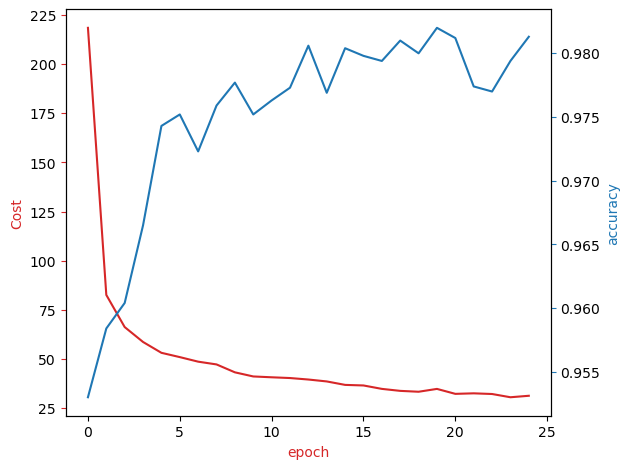

In [16]:
# Plot the loss and accuracy

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(cost_list, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('Cost', color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color) 
ax2.set_xlabel('epoch', color=color)
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

The accuracy plot has a zigzag movement which shows the effect of momentum, accuracy converges more faster.

View the results of the parameters for the Convolutional layers 


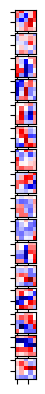

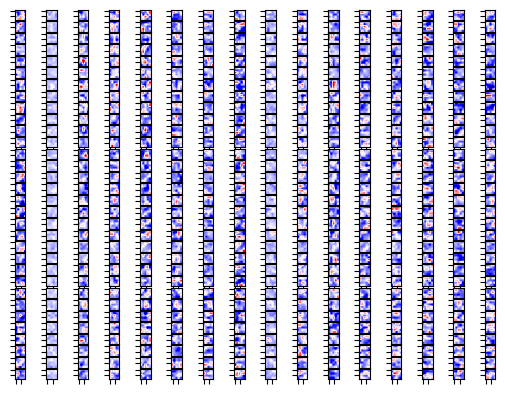

In [17]:
# Plot the channels

plot_channels(model.state_dict()['cnn1.weight'])
plot_channels(model.state_dict()['cnn2.weight'])

Plot the kernels parameters for each layer after training

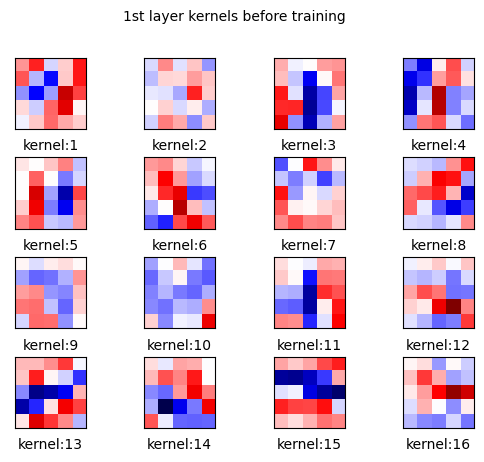

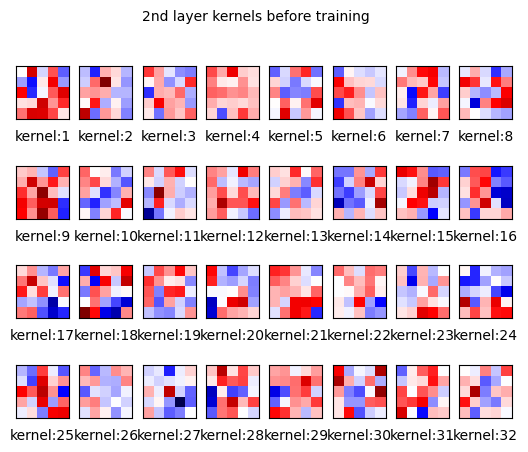

In [18]:
# Plot the parameters

plot_parameters(model.state_dict()['cnn1.weight'], number_rows=4, name="1st layer kernels before training ")
plot_parameters(model.state_dict()['cnn2.weight'], number_rows=4, name='2nd layer kernels before training' )